## 들어가며
CAM(Class Activation Map)을 얻기 위한 방법 중 기본 CAM 과 Grad-CAM을 구현해보고 시각화 해보겠습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CAM, Grad-CAM용 모델 준비하기 , 데이터셋 준비
CAM은 특성을 추출하는 CNN 네트워크 뒤에 GAP과 softmax layer가 구성되야 한다는 제약이 있습니다(학습해야할 파라미터 수가 많다).
반면에 , Grad-CAM 은 이러한 제약이 없습니다.  


CAM은 클래스에 대한 활성화 정도를 나타낸 지도입니다. 따라서 기본적으로 CAM을 위한 모델은 classification을 수행하는 모델이어야 합니다. 하지만 최종 목표는 이미지 내에서 클래스가 활성화된 위치를 확인하고 정답과 비교하는 것이므로 위치정보가 기록된 데이터가 함께 있어야 합니다.  

tensorflow dataset의 stanford_dogs 데이터셋은 라벨에 클래스 위치 정보인 바운딩 박스 정보를 포함하고 있습니다.


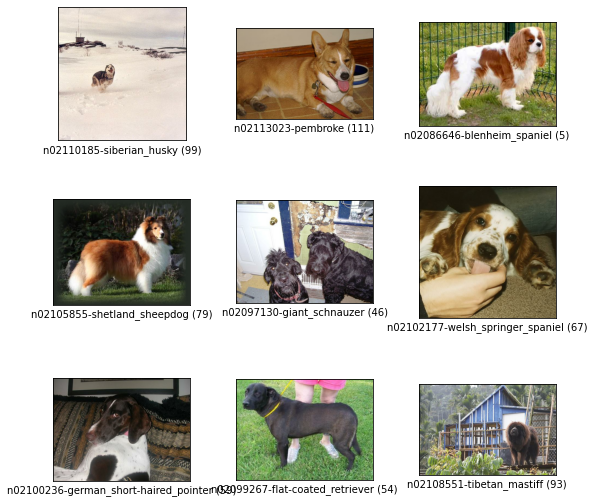

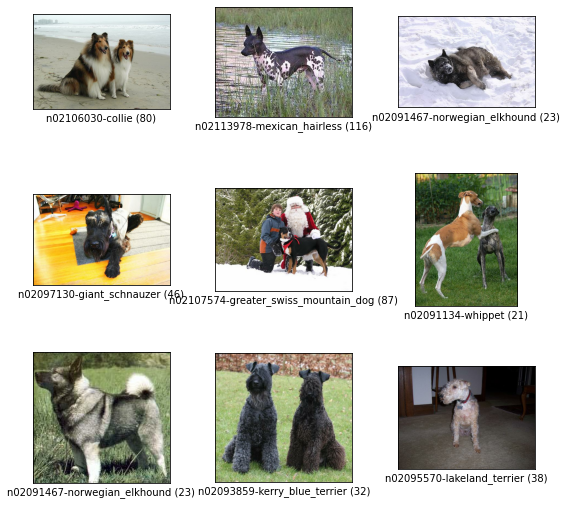

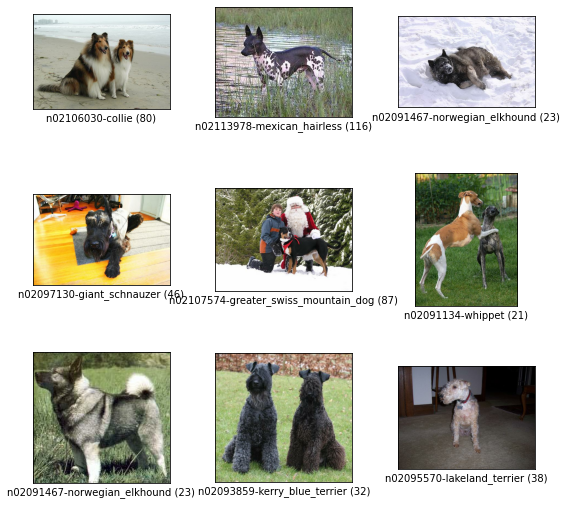

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)
tfds.show_examples(ds_test, ds_info)

## CAM, Grad-CAM용 모델 준비하기, 물체의 위치정보


In [3]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

image와 label은 이미지와 정답클래스의 idx입니다.  
bbox는 물체의 위치를 사각형 영역으로 표기하는 방법입니다.
tfds 에선 BBoxFeature라는 타입으로 정의되어 있습니다.

바운딩 박스를 표기하는 방법
* (x_center,y_center,width,height)
    * 중심점이 아니라 좌 상단을 가리킬 수도 있습니다.
* (x_min,x_max,y_min,y_max) <- 저번에 해본거!
    * 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.


바운딩 박스 표기법은 이것 말고도 다양하기때문에 새로운 데이터셋을 접할때 바운딩 박스 정보를 확인하고 넘어가는 것이 좋습니다.

## CAM, Grad-CAM용 모델 준비하기, CAM을 위한 모델 만들기
미리 이미지넷 데이터에 훈련된 resnet-50을 기반으로 하고, pooling layer 뒤에 softmax layer를 붙여 CAM모델을 만들겠습니다.


In [4]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes,activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

일반적인 분류모델과는 달리 마지막에 FC 레이어 대신 GAP이 적용됩니다.

In [5]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

> CAM은 특성맵을 이용해 만드는데 특성맵은 GAP연산을 적용하기 전의 output layer인 conv5_block5_out의 출력값이 됩니다.
여기서 GAP로 feature의 크기를 줄이고 FC로 classification을 수행합니다.

## CAM,Grad-CAM용 모델 준비하기, CAM 모델 학습하기

학습 데이터와 검증 데이터에 normalizing과 resizeing을 포함한 전처리를 normalize_and_resize_img 에서 수행하며, apply_normalize_on_dataset 에서 배치를 구성합니다.

input에 이전과 다르게 bbox정보가 포함되어있지만 지금 수행할 CAM 모델의 학습에는 필요하지 않으므로 전처리 과정에서 제외해줍니다.

* CAM 모델은 bounding box같은 직접적인 라벨을 사용하지않고 weakly supervised learning을 통해 물체영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [6]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'],[224,224])
    input['image'] = tf.cast(image,tf.float32)/ 255.
    return input['image'],input['label']

def apply_normalize_on_dataset(ds,is_test=False,batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test,is_test = True)

In [8]:
for input in ds_train_norm.take(1):
    image,label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


모델을 컴파일합니다.

In [9]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## CAM

학습된 모델에서 CAM을 생성할때 배치단위가 아니라 개별 이미지 단위로 이루어지기 때문에 데이터셋에서 하나를 뽑을 수 있는 함수를 정의합니다.

In [10]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

108


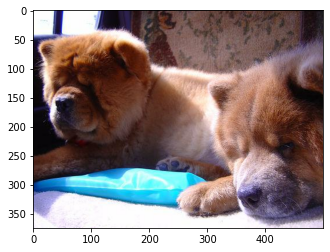

In [11]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

CAM을 생성하기 위해서는 특성 맵, 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 원하는 클래스의 출력값이 필요합니다.  

또, 이미지에서 어떤 부분을 보는지 직관적으로 확인하기 위해 CAM을 입력 이미지 사이즈와 같게 만들어야합니다.


In [12]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    # input에 대한 output을 CAM과 predict 두개를 받음
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


사전에 훈련된 모델의 가중치를 가지고 옵니다.

In [13]:
import os
cam_model_path = '/content/drive/MyDrive/node/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 얻어보겠습니다.

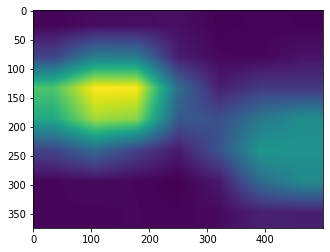

In [14]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [15]:
# 원본 이미지와 CAM을 합쳐주는 함수
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

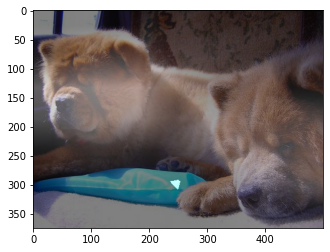

In [16]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

CAM이 개를 식별하는데 중요한 부분을 집중해서 포착한 모습입니다.

## Grad-CAM


이번에는 Grad-CAM을 이용해 CAM을 얻어보도록 하겠습니다.  
모델 구조를 수정할 필요가 없어 적용 모델을 유용하게 선택 가능한 Grad-CAM 특성상 위에서 만들었던 모델을 재활용하도록 합니다.  

새로운 이미지를 뽑아봅니다.

67


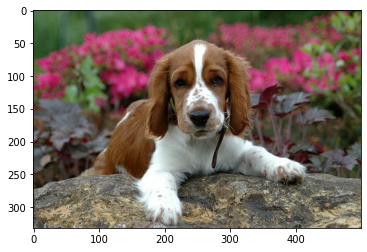

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

Grad-CAM은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고 여기어 GAP을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다.  

최종적인 CAM이미지를 구하기 위해 레이어의 채널별 가중치와 채널별 특성 맵을 가중합해주어 얻을 수 있습니다.

In [18]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.
        
    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

여러 Activation layer의 Grad-CAM을 뽑아봅니다.

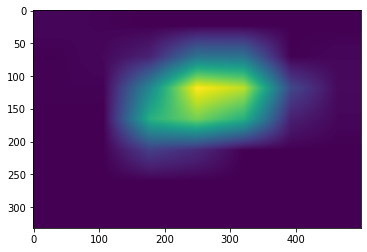

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

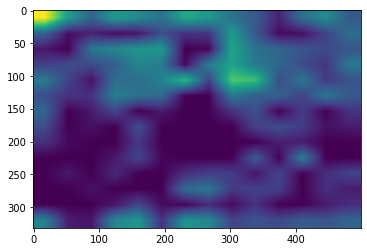

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

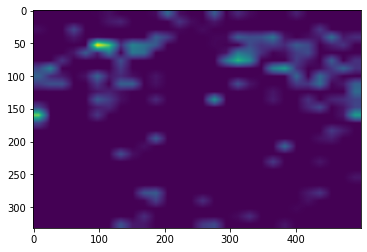

In [21]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Detection with CAM


마지막으로 CAM에서 물체의 위치를 찾아 detection 해보도록 합니다.  

새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아봅시다.

80


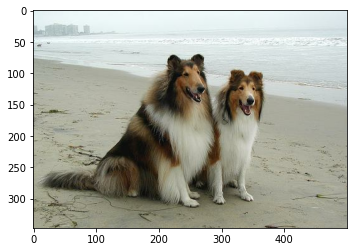

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

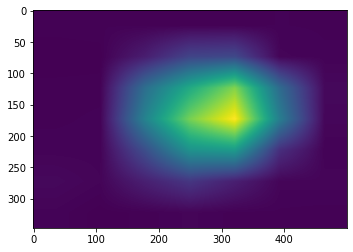

In [23]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

CAM으로부터 Bounding Box를 획득할 get_bbox 함수를 정의합니다.  

get_bbox 함수는 바운딩 박스를 만들기 위해 score_thresh를 받아 역치값 이하의 바운딩 박스를 없앱니다.  

이후, OpenCV의 findContours() 와 minAreaRect()로 사각형을 찾습니다.  

이때 rotated_rect라는 회전된 바운딩 박스를 얻을 수 있는데 이걸 box_Points()로 꼭지점으로 바꿉니다.

In [24]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [25]:
rect = get_bbox(cam_image)
rect

array([[118, 310],
       [111,  40],
       [453,  32],
       [460, 302]])

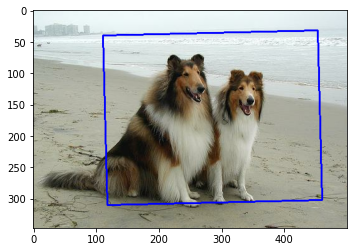

In [26]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Bbox를 어떻게 평가할까
위에서 CAM과 Grad-CAM으로 바운딩 박스를 예측했습니다.  

그럼 정답 바운딩 박스와 어떻게 비교 평가할까요?  

IoU(Intersection over Union)은 두 영역의 교집합인 intersection 영역의 크기를 합집합인 Union의 값으로 나눠준 값입니다.  
간단히, 두 바운딩 박스가 겹쳐져있는 정도라고 생각하면 됩니다.


In [27]:
# rect 좌표를 이미지의 상대죄표로 바꿔주며 정답 bbox와 표현방식을 맞춰줍니다..
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [28]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09221902017291066, 0.222, 0.8933717579250721, 0.92]

In [29]:
# 정답 bbox 입니다.
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

iou를 계산합니다.

In [30]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [31]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.35141132309225515